# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [621]:
# import libraries

import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn
import psycopg2 as psy
import seaborn as sns

from psycopg2 import connect
import sys
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
%matplotlib inline
#plt.style.use("ggplot")
plt.style.use('fivethirtyeight')

from collections import Counter
from __future__ import division
from matplotlib.ticker import AutoMinorLocator, FixedLocator
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


#### Step 2: Examine your data 

In [3]:
#copied the CSV(s) on /Users/mariapichardo/DSI-NYC-2/projects/projects-weekly/project-07/assets to Local

In [622]:
## Load the data into a DataFrame for Airport_operations.csv
air_oper = pd.read_csv('Airport_operations.csv', encoding='latin1')

In [623]:
air_oper.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [624]:
air_oper['airport'].nunique()

77

In [625]:
#set column names to lower case to facilitate sql statements
air_oper.columns = [i.lower() for i in air_oper.columns.values]

In [626]:
# replace space for '_' to facilitate sql statements
air_oper.columns = [i.replace(" ", "_") if ' ' in i else i for i in air_oper.columns.values]

In [627]:
## Load the data into a DataFrame for airport_cancellations.csv
air_cancel = pd.read_csv('airport_cancellations.csv', encoding='latin1')

In [628]:
air_cancel.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [629]:
# set column names to lower case to facilitate sql statements
air_cancel.columns = [i.lower() for i in air_cancel.columns.values]

In [630]:
# replace space for '_' to facilitate sql statements
air_cancel.columns = [i.replace(" ", "_") if ' ' in i else i for i in air_cancel.columns.values]

In [631]:
air_cancel.head()

,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [632]:
## Load the data into a DataFrame for airports.csv
airports = pd.read_csv('airports.csv', encoding='latin1')

In [633]:
airports.head()

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodrï¿½guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


In [634]:
# set column names to lower case to facilitate sql statements
airports.columns = [i.lower() for i in airports.columns.values]

In [635]:
# replace space for '_' to facilitate sql statements
airports.columns = [i.replace(" ", "_") if ' ' in i else i for i in airports.columns.values]

In [636]:
airports.head(2)

,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No


In [637]:
print "\n"
print "air_cancel total records ", len(air_cancel)
print "\n"
print "air_oper total records ", len(air_oper)
print "\n"
print "airports total records ", len(airports)
print "\n"



air_cancel total records  805


air_oper total records  841


airports total records  5167




In [679]:
airports['locid'].nunique()

5152

In [638]:
#check null values before moving data to a Database
print np.sum(air_cancel.isnull())

airport                    0
year                       0
departure_cancellations    0
arrival_cancellations      0
departure_diversions       0
arrival_diversions         0
dtype: int64


In [639]:
print np.sum(air_oper.isnull())

airport                               0
year                                  0
departures_for_metric_computation     0
arrivals_for_metric_computation       0
percent_on-time_gate_departures       0
percent_on-time_airport_departures    0
percent_on-time_gate_arrivals         0
average_gate_departure_delay          0
average_taxi_out_time                 0
average_taxi_out_delay                0
average_airport_departure_delay       0
average_airborne_delay                0
average_taxi_in_delay                 0
average_block_delay                   0
average_gate_arrival_delay            0
dtype: int64


In [680]:
print np.sum(airports.isnull())

key                           0
locid                         0
ap_name                       0
alias                      1654
facility_type                 0
faa_region                    0
county                        0
city                          0
state                         0
ap_type                       0
latitude                      0
longitude                     0
boundary_data_available       0
dtype: int64


In [641]:
airports[airports['key'].isnull()]

,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available
5164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [642]:
#Remove those 3 null records in airport
airports = airports[airports.key.notnull()]

In [643]:
 #airports[airports.locid.isnull()]
airports[airports['locid'].isnull()]['key']  

182     5238.0
1208    4838.0
1232    5139.0
1233    5197.0
1408    5199.0
2670    4960.0
2789    4224.0
3354    4501.0
3546    4568.0
3936    4905.0
4200    5106.0
4450    4786.0
Name: key, dtype: float64

In [644]:
#Remove records for null locid(s)
airports = airports[airports.locid.notnull()]

### Intro: Write a problem statement / aim (or purpose) for this project

#### The FAA is noticing significant delays with certain airports. Over the years some delay times have not improved or have worsened. They  hired me as a consultant to analyze the operations of major airports around the country because they want to cut down on delays nationwide. My main task is to understand the distribution, characteristics, and components of individual airports operations that are leading to these delays.

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [324]:
#%load_ext sql
# connecting to local host 
con = connect(user='mariapichardo', host='localhost')
con.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
cur = con.cursor()
# creating database in SQL server 
cur.execute('create Database airport;')
# if you want to drop the database uncomment statement below
#cur.execute('drop Database airport;')

In [325]:
# create engine to run sql commands 
engine = create_engine('postgresql://mariapichardo@localhost:5432/airport')
connect_pos = engine.connect()

Load our csv files into tables

In [605]:
# convert df to sql tables 
air_cancel.to_sql('air_cancel', engine, if_exists='replace')
air_oper.to_sql('air_oper', engine, if_exists='replace')
airports.to_sql('airports', engine, if_exists='replace')

In [645]:
# connect to postgres database 
%sql postgresql://mariapichardo@localhost:5432/airport

u'Connected: mariapichardo@airport'

In [646]:
%load_ext sql
#%reload_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [ ]:
# The statements below if for killing sessions in case you want to drop the database to re-create it again

In [616]:
# %%sql
# SELECT 
#     pg_terminate_backend(pid) 
# FROM 
#     pg_stat_activity 
# WHERE 
#     -- if I don't want to kill my own connection uncomment the below statement
#     -- pid <> pg_backend_pid() AND datname = 'airport'
#     -- don't kill the connections to other databases only the 'airport'
#     datname = 'airport'
#     ;

(psycopg2.OperationalError) terminating connection due to administrator command
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.
 [SQL: "SELECT \n    pg_terminate_backend(pid) \nFROM \n    pg_stat_activity \nWHERE \n    -- if I don't want to kill my own connection uncomment the below statement\n    -- pid <> pg_backend_pid() AND datname = 'airport'\n    -- don't kill the connections to other databases only the 'airport'\n    datname = 'airport'\n    ;"]


In [617]:
%%sql
SELECT count(*) from airports;

1 rows affected.


count
5152


In [647]:
%%sql
SELECT * from airports limit 5;

5 rows affected.


index,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,None,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.01933,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodrï¿½guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


Join airport_cancellations.csv and airports.csv into one table

In [333]:
#   Table Descriptions below to facilitate bulding the sql statements
#
#          Column          |       Type       | Modifiers 
# -------------------------+------------------+-----------
#  index                   | bigint           | 
#  key                     | double precision | 
#  locid                   | text             | 
#  ap_name                 | text             | 
#  alias                   | text             | 
#  facility_type           | text             | 
#  faa_region              | text             | 
#  county                  | text             | 
#  city                    | text             | 
#  state                   | text             | 
#  ap_type                 | text             | 
#  latitude                | double precision | 
#  longitude               | double precision | 
#  boundary_data_available | text             | 
# Indexes:
#     "ix_airports_index" btree (index)
#
# airport=# \d air_cancel
#                Table "public.air_cancel"
#          Column          |       Type       | Modifiers 
# -------------------------+------------------+-----------
#  index                   | bigint           | 
#  airport                 | text             | 
#  year                    | double precision | 
#  departure_cancellations | double precision | 
#  arrival_cancellations   | double precision | 
#  departure_diversions    | double precision | 
#  arrival_diversions      | double precision | 
#
# airport=# \d air_oper
#                       Table "public.air_oper"
#                Column               |       Type       | Modifiers 
# ------------------------------------+------------------+-----------
#  index                              | bigint           | 
#  airport                            | text             | 
#  year                               | bigint           | 
#  departures_for_metric_computation  | bigint           | 
#  arrivals_for_metric_computation    | bigint           | 
#  percent_on-time_gate_departures    | double precision | 
#  percent_on-time_airport_departures | double precision | 
#  percent_on-time_gate_arrivals      | double precision | 
#  average_gate_departure_delay       | double precision | 
#  average_taxi_out_time              | double precision | 
#  average_taxi_out_delay             | double precision | 
#  average_airport_departure_delay    | double precision | 
#  average_airborne_delay             | double precision | 
#  average_taxi_in_delay              | double precision | 
#  average_block_delay                | double precision | 
#  average_gate_arrival_delay         | double precision | 


In [334]:
#rename the air_cancel index column before creataing the join tables

In [618]:
%%sql
ALTER TABLE air_cancel RENAME index TO index_cancel;

(psycopg2.ProgrammingError) column "index" does not exist
 [SQL: 'ALTER TABLE air_cancel RENAME index TO index_cancel;']


In [176]:
#rename the air_oper index column before creataing the join tables

In [611]:
%%sql
ALTER TABLE air_oper RENAME index TO index_oper;

Done.


[]

In [619]:
%%sql
CREATE TABLE airport_plus_cancel AS
 SELECT * from airports
    FULL JOIN air_cancel
    ON airports.locid = air_cancel.airport;

5883 rows affected.


[]

Query the database for our intial data

In [649]:
%%sql
select * 
FROM airport_plus_cancel 
limit 15;

15 rows affected.


index,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available,index_cancel,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,0,ABQ,2004.0,242.0,235.0,71.0,46.0
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,1,ABQ,2005.0,221.0,190.0,61.0,33.0
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,2,ABQ,2006.0,392.0,329.0,71.0,124.0
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,3,ABQ,2007.0,366.0,304.0,107.0,45.0
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,4,ABQ,2008.0,333.0,300.0,79.0,42.0
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,5,ABQ,2009.0,192.0,162.0,74.0,26.0
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,6,ABQ,2010.0,222.0,177.0,71.0,50.0
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,7,ABQ,2011.0,345.0,294.0,77.0,61.0
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,8,ABQ,2012.0,237.0,181.0,65.0,60.0
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,9,ABQ,2013.0,232.0,212.0,62.0,46.0


In [340]:
# join the three tables  - rename columns before

In [653]:
%%sql
ALTER TABLE air_oper RENAME airport TO airport_oper;

Done.


[]

In [654]:
%%sql
ALTER TABLE air_oper RENAME year TO year_oper;

Done.


[]

In [655]:
%%sql
CREATE TABLE airport_complete AS
    SELECT * from airport_plus_cancel
    JOIN air_oper
    ON (air_oper.airport_oper  = airport_plus_cancel.airport and air_oper.year_oper = airport_plus_cancel.year );

799 rows affected.


[]

In [656]:
%%sql
select * 
FROM airport_complete 
limit 15;

15 rows affected.


index,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available,index_cancel,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,index_oper,airport_oper,year_oper,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,0,ABQ,2004.0,242.0,235.0,71.0,46.0,0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,1,ABQ,2005.0,221.0,190.0,61.0,33.0,1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.6,9.79,2.29,11.2,2.26,0.89,2.34,10.24
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,2,ABQ,2006.0,392.0,329.0,71.0,124.0,2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,3,ABQ,2007.0,366.0,304.0,107.0,45.0,3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.4,12.95,2.19,1.29,3.06,12.71
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,4,ABQ,2008.0,333.0,300.0,79.0,42.0,4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,5,ABQ,2009.0,192.0,162.0,74.0,26.0,5,ABQ,2009,42550,42704,0.8341,0.8147,0.8224,9.24,9.88,1.89,10.45,1.74,0.92,1.98,9.27
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,6,ABQ,2010.0,222.0,177.0,71.0,50.0,6,ABQ,2010,42302,42169,0.8144,0.7907,0.8047,10.25,9.95,2.05,11.58,1.66,0.95,1.9,10.23
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,7,ABQ,2011.0,345.0,294.0,77.0,61.0,7,ABQ,2011,42283,42297,0.8072,0.7758,0.8022,10.81,10.5,2.51,12.57,1.58,0.84,1.87,10.63
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,8,ABQ,2012.0,237.0,181.0,65.0,60.0,8,ABQ,2012,39105,39107,0.8219,0.794,0.8177,10.55,10.27,2.32,12.11,1.41,0.98,1.8,9.73
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,9,ABQ,2013.0,232.0,212.0,62.0,46.0,9,ABQ,2013,35277,34989,0.771,0.7402,0.7554,12.56,10.77,2.64,14.28,1.6,0.92,2.35,12.76


In [683]:
%%sql
select locid, year 
FROM airport_complete 
group by locid, year
order by locid, year limit 15;

15 rows affected.


locid,year
ABQ,2004.0
ABQ,2005.0
ABQ,2006.0
ABQ,2007.0
ABQ,2008.0
ABQ,2009.0
ABQ,2010.0
ABQ,2011.0
ABQ,2012.0
ABQ,2013.0


In [686]:
%%sql
select locid, ap_name, count(year) 
FROM airport_complete 
group by locid, ap_name
having count(year) <> 11
order by locid;

4 rows affected.


locid,ap_name,count
OXR,OXNARD,7
PSP,PALM SPRINGS INTL,8
RFD,CHICAGO/ROCKFORD INTL,6
SMF,SACRAMENTO INTL,8


In [687]:
%%sql
select locid, ap_name, count(year) 
FROM airport_complete 
group by locid, ap_name
having count(year) = 11
order by locid;

70 rows affected.


locid,ap_name,count
ABQ,ALBUQUERQUE INTL SUNPORT,11
ANC,TED STEVENS ANCHORAGE INTL,11
ATL,HARTSFIELD - JACKSON ATLANTA INTL,11
AUS,AUSTIN-BERGSTROM INTL,11
BDL,BRADLEY INTL,11
BHM,BIRMINGHAM-SHUTTLESWORTH INTL,11
BNA,NASHVILLE INTL,11
BOS,GENERAL EDWARD LAWRENCE LOGAN INTL,11
BUF,BUFFALO NIAGARA INTL,11
BUR,BOB HOPE,11


In [813]:
airport_totaldf.columns

Index([                             u'index',
                                      u'key',
                                    u'locid',
                                  u'ap_name',
                                    u'alias',
                            u'facility_type',
                               u'faa_region',
                                   u'county',
                                     u'city',
                                    u'state',
                                  u'ap_type',
                                 u'latitude',
                                u'longitude',
                  u'boundary_data_available',
                             u'index_cancel',
                                  u'airport',
                                     u'year',
                  u'departure_cancellations',
                    u'arrival_cancellations',
                     u'departure_diversions',
                       u'arrival_diversions',
                               u'i

In [838]:
%%sql
--select locid, ap_name, year, sum(departure_cancellations) 
--FROM airport_complete 
--group by locid, ap_name, year
--order by sum(departure_cancellations) desc;

select locid as airport, ap_name , sum(departure_cancellations) as total_dep_cancellations, 
sum(departure_diversions) as total_dep_diversions
FROM airport_complete 
group by locid, ap_name
order by sum(departure_cancellations) desc limit 5;

5 rows affected.


airport,ap_name,total_dep_cancellations,total_dep_diversions
ORD,CHICAGO O'HARE INTL,119812.0,8085.0
ATL,HARTSFIELD - JACKSON ATLANTA INTL,72186.0,9729.0
DFW,DALLAS/FORT WORTH INTL,66503.0,7202.0
LGA,LA GUARDIA,50663.0,2796.0
EWR,NEWARK LIBERTY INTL,46661.0,3582.0


In [1095]:
%%sql
select locid as airport, ap_name , sum(departure_cancellations) as total_dep_cancellations, 
sum(departure_diversions) as total_dep_diversions
FROM airport_complete 
where year = 2014
group by locid, ap_name
order by sum(departure_cancellations) desc limit 5;

5 rows affected.


airport,ap_name,total_dep_cancellations,total_dep_diversions
ORD,CHICAGO O'HARE INTL,13454.0,739.0
DFW,DALLAS/FORT WORTH INTL,6830.0,741.0
ATL,HARTSFIELD - JACKSON ATLANTA INTL,5977.0,781.0
EWR,NEWARK LIBERTY INTL,4814.0,349.0
LGA,LA GUARDIA,4672.0,247.0


In [1094]:
%%sql
select locid, ap_name, year, sum(departure_cancellations) 
FROM airport_complete 
where locid in ('ORD', 'ATL', 'DFW', 'LGA', 'EWR')
group by locid, ap_name, year
order by ap_name, year, sum(departure_cancellations); 

55 rows affected.


locid,ap_name,year,sum
ORD,CHICAGO O'HARE INTL,2004.0,11725.0
ORD,CHICAGO O'HARE INTL,2005.0,8466.0
ORD,CHICAGO O'HARE INTL,2006.0,12915.0
ORD,CHICAGO O'HARE INTL,2007.0,16618.0
ORD,CHICAGO O'HARE INTL,2008.0,15050.0
ORD,CHICAGO O'HARE INTL,2009.0,6827.0
ORD,CHICAGO O'HARE INTL,2010.0,7786.0
ORD,CHICAGO O'HARE INTL,2011.0,11659.0
ORD,CHICAGO O'HARE INTL,2012.0,6157.0
ORD,CHICAGO O'HARE INTL,2013.0,9155.0


In [853]:
%%sql
select locid as airport, ap_name , max(average_airport_departure_delay) as max_aver_air_dep_delay
FROM airport_complete 
group by locid, ap_name
order by max(average_airport_departure_delay) desc limit 10;

10 rows affected.


airport,ap_name,max_aver_air_dep_delay
JFK,JOHN F KENNEDY INTL,40.51
EWR,NEWARK LIBERTY INTL,35.34
LGA,LA GUARDIA,33.26
HPN,WESTCHESTER COUNTY,30.62
PHL,PHILADELPHIA INTL,30.2
ORD,CHICAGO O'HARE INTL,27.34
ATL,HARTSFIELD - JACKSON ATLANTA INTL,24.85
MDW,CHICAGO MIDWAY INTL,23.11
IAD,WASHINGTON DULLES INTL,23.11
ANC,TED STEVENS ANCHORAGE INTL,23.05


In [852]:
%%sql
select locid as airport, ap_name , sum(arrival_cancellations) as total_arr_cancellations, 
sum(arrival_diversions) as total_arr_diversions
FROM airport_complete 
group by locid, ap_name
order by sum(arrival_cancellations) desc limit 10;

10 rows affected.


airport,ap_name,total_arr_cancellations,total_arr_diversions
ORD,CHICAGO O'HARE INTL,129035.0,8460.0
ATL,HARTSFIELD - JACKSON ATLANTA INTL,80490.0,9594.0
DFW,DALLAS/FORT WORTH INTL,70729.0,13440.0
LGA,LA GUARDIA,50157.0,5691.0
EWR,NEWARK LIBERTY INTL,47906.0,5285.0
BOS,GENERAL EDWARD LAWRENCE LOGAN INTL,33650.0,1553.0
DEN,DENVER INTL,32807.0,5149.0
SFO,SAN FRANCISCO INTL,32160.0,2867.0
LAX,LOS ANGELES INTL,29877.0,2807.0
IAH,GEORGE BUSH INTERCONTINENTAL/HOUSTON,27513.0,8562.0


In [1140]:
%%sql
select locid as airport, ap_name , max("percent_on-time_airport_departures") as Max_perc_on_time_air_departures
FROM airport_complete 
--where year = 2014
group by locid, ap_name
order by max("percent_on-time_airport_departures")  desc limit 10;

10 rows affected.


airport,ap_name,max_perc_on_time_air_departures
OGG,KAHULUI,0.8974
HNL,HONOLULU INTL,0.8823
OXR,OXNARD,0.8739
LGB,LONG BEACH /DAUGHERTY FIELD/,0.8544
SEA,SEATTLE-TACOMA INTL,0.8507
PDX,PORTLAND INTL,0.8421
TUS,TUCSON INTL,0.8336
SJC,NORMAN Y. MINETA SAN JOSE INTL,0.8324
BUR,BOB HOPE,0.8302
RSW,SOUTHWEST FLORIDA INTL,0.8297


In [1096]:
%%sql
select locid as airport, ap_name , max("percent_on-time_airport_departures") as better_perc_on_time_air_departures
FROM airport_complete 
group by locid, ap_name
order by max("percent_on-time_airport_departures")  limit 10;

10 rows affected.


airport,ap_name,better_perc_on_time_air_departures
HPN,WESTCHESTER COUNTY,0.5851
EWR,NEWARK LIBERTY INTL,0.61
LGA,LA GUARDIA,0.621
JFK,JOHN F KENNEDY INTL,0.6409
PHL,PHILADELPHIA INTL,0.6951
SDF,LOUISVILLE INTL-STANDIFORD FIELD,0.6973
MEM,MEMPHIS INTL,0.7
MDW,CHICAGO MIDWAY INTL,0.7014
PBI,PALM BEACH INTL,0.7109
HOU,WILLIAM P HOBBY,0.7209


In [1082]:
%%sql
select locid as airport, ap_name , max(average_taxi_out_delay) as avererage_taxi_out_delay
FROM airport_complete 
group by locid, ap_name
order by max(average_taxi_out_delay) desc limit 10;

10 rows affected.


airport,ap_name,avererage_taxi_out_delay
JFK,JOHN F KENNEDY INTL,18.94
EWR,NEWARK LIBERTY INTL,15.63
LGA,LA GUARDIA,15.0
PHL,PHILADELPHIA INTL,11.2
ATL,HARTSFIELD - JACKSON ATLANTA INTL,9.73
IAH,GEORGE BUSH INTERCONTINENTAL/HOUSTON,9.56
ORD,CHICAGO O'HARE INTL,9.36
CLT,CHARLOTTE/DOUGLAS INTL,7.78
MSP,MINNEAPOLIS-ST PAUL INTL/WOLD-CHAMBERLAIN,7.27
IAD,WASHINGTON DULLES INTL,7.17


### Create a dataframe with all columns

In [657]:
airport_complete = connect_pos.execute("select * FROM airport_complete")

In [658]:
airport_totaldf = pd.DataFrame(airport_complete.fetchall())
airport_totaldf.columns = airport_complete.keys()

In [659]:
airport_totaldf.head()

,index,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,...,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [660]:
airport_totaldf.columns

Index([u'index', u'key', u'locid', u'ap_name', u'alias', u'facility_type',
       u'faa_region', u'county', u'city', u'state', u'ap_type', u'latitude',
       u'longitude', u'boundary_data_available', u'index_cancel', u'airport',
       u'year', u'departure_cancellations', u'arrival_cancellations',
       u'departure_diversions', u'arrival_diversions', u'index_oper',
       u'airport_oper', u'year_oper', u'departures_for_metric_computation',
       u'arrivals_for_metric_computation', u'percent_on-time_gate_departures',
       u'percent_on-time_airport_departures', u'percent_on-time_gate_arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average_taxi_out_delay', u'average_airport_departure_delay',
       u'average_airborne_delay', u'average_taxi_in_delay',
       u'average_block_delay', u'average_gate_arrival_delay'],
      dtype='object')

In [661]:
len(airport_totaldf)

799

#### 1.2 What are the risks and assumptions of our data? 

We only have 799 records in total. Only 74 airports are included in the dataset. We do not have other factors for delays like the ones related to weather which can be quite common or mechanical problems with the airplanes, strikes...etc. Due to this our analysis will be based on the delay and diversion information present in the data set.

The following airports do not have information for all the years
- OXR-OXNARD	              7 years
- PSP-PALM SPRINGS INTL	  8 years
- RFD-CHICAGO/ROCKFORD INTL 6 years
- SMF-SACRAMENTO INTL	      8 years


### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [663]:
airport_totaldf.dtypes

index                                   int64
key                                   float64
locid                                  object
ap_name                                object
alias                                  object
facility_type                          object
faa_region                             object
county                                 object
city                                   object
state                                  object
ap_type                                object
latitude                              float64
longitude                             float64
boundary_data_available                object
index_cancel                            int64
airport                                object
year                                  float64
departure_cancellations               float64
arrival_cancellations                 float64
departure_diversions                  float64
arrival_diversions                    float64
index_oper                        

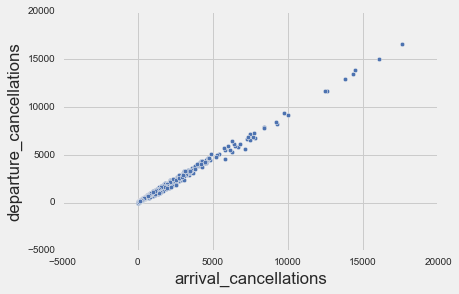

In [688]:
# relationship arrival cancellations and departure cancellations 
airport_totaldf.plot(kind='scatter',x= 'arrival_cancellations',y='departure_cancellations')

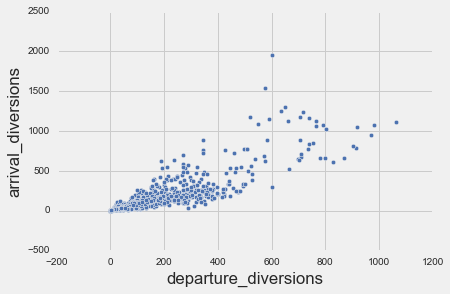

In [689]:
# relationship arrival cancellations and departure cancellations 
airport_totaldf.plot(kind='scatter',x= 'departure_diversions',y='arrival_diversions')

In [666]:
np.mean(airport_totaldf[airport_totaldf['year']==2005]['departure_cancellations'])

1501.3239436619717

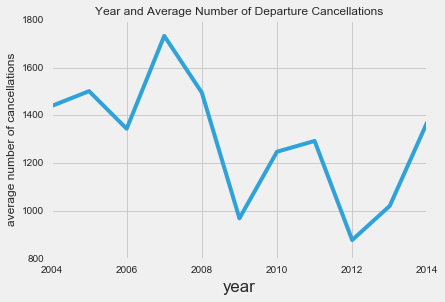

In [1100]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
# check the average trend in departure cancellation
dep_cancel_per_year = pd.pivot_table(airport_totaldf, index = 'year', values = 'departure_cancellations')
plt.figure()
dep_cancel_per_year.plot()
plt.title('Year and Average Number of Departure Cancellations', fontsize =12)
plt.ylabel('average number of cancellations', fontsize =12)

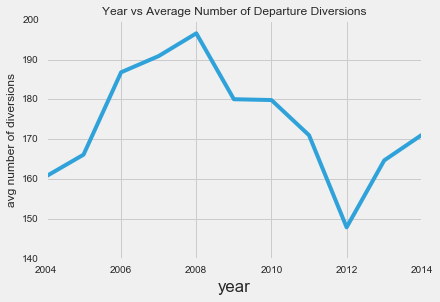

In [1104]:
# check the trend in departure diversions
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
dep_divers_per_year = pd.pivot_table(airport_totaldf, index = 'year', values = 'departure_diversions')
plt.figure()
dep_divers_per_year.plot()
plt.title('Year vs Average Number of Departure Diversions', fontsize =12)
plt.ylabel('avg number of diversions', fontsize =12)

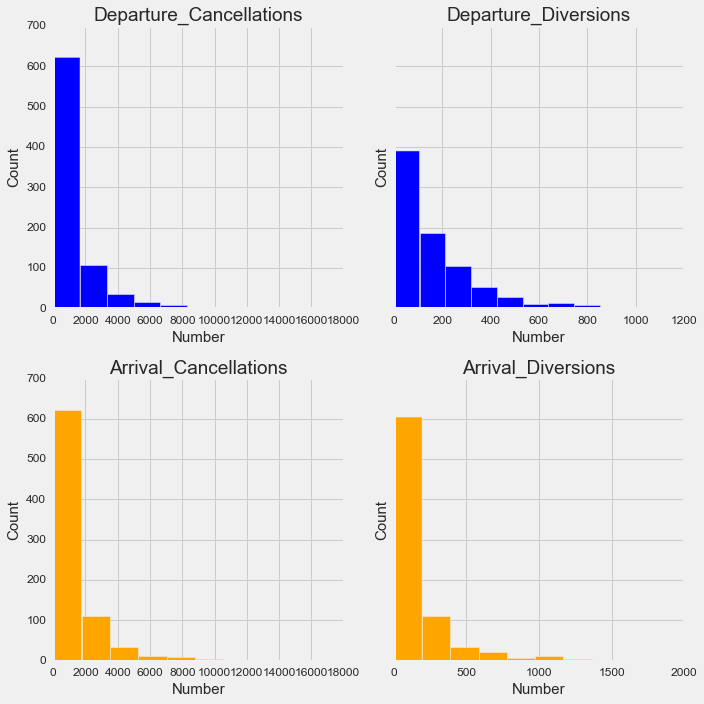

In [669]:
# distributions of cancellations / diversions
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10),sharey=True)
for ax, var, c in zip([ax1,ax2,ax3,ax4],["departure_cancellations","departure_diversions","arrival_cancellations",\
                                     "arrival_diversions"],["blue","blue","orange","orange"]):

    airport_totaldf[var].hist(ax=ax, color=c)
    ax.set_title(var.title(), fontsize=19)
    ax.tick_params(labelsize=12)

ax1.set_xlabel("Number", fontsize=15)
ax1.set_ylabel("Count", fontsize=15)
ax2.set_xlabel("Number", fontsize=15)
ax2.set_ylabel("Count", fontsize=15)
ax3.set_xlabel("Number", fontsize=15)
ax3.set_ylabel("Count", fontsize=15)
ax4.set_xlabel("Number", fontsize=15)
ax4.set_ylabel("Count", fontsize=15)
plt.tight_layout()

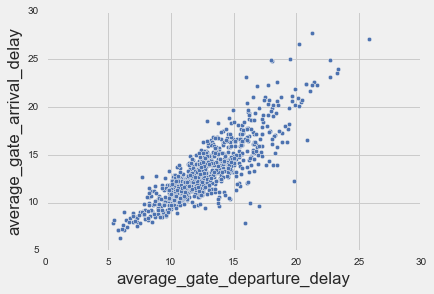

In [670]:
# relationship 
airport_totaldf.plot(kind='scatter',x= 'average_gate_departure_delay',y='average_gate_arrival_delay')

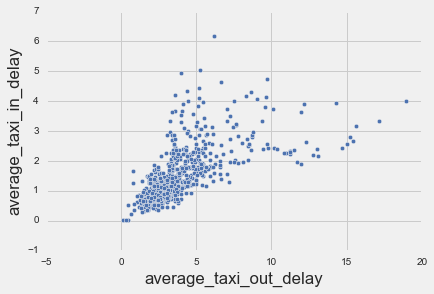

In [671]:
# relationship 
airport_totaldf.plot(kind='scatter',x= 'average_taxi_out_delay',y='average_taxi_in_delay')

#### Are there any unique values? 

In [672]:
airport_totaldf.columns

Index([u'index', u'key', u'locid', u'ap_name', u'alias', u'facility_type',
       u'faa_region', u'county', u'city', u'state', u'ap_type', u'latitude',
       u'longitude', u'boundary_data_available', u'index_cancel', u'airport',
       u'year', u'departure_cancellations', u'arrival_cancellations',
       u'departure_diversions', u'arrival_diversions', u'index_oper',
       u'airport_oper', u'year_oper', u'departures_for_metric_computation',
       u'arrivals_for_metric_computation', u'percent_on-time_gate_departures',
       u'percent_on-time_airport_departures', u'percent_on-time_gate_arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average_taxi_out_delay', u'average_airport_departure_delay',
       u'average_airborne_delay', u'average_taxi_in_delay',
       u'average_block_delay', u'average_gate_arrival_delay'],
      dtype='object')

In [673]:
column_list = ['key', 'locid', 'ap_name', 'boundary_data_available', 'alias', 'facility_type','faa_region',\
               'county', 'city', 'state', 'ap_type','airport','year']
for column_name in column_list:
     print 'unique for ',  column_name, airport_totaldf[column_name].unique()

unique for  key [ 2348.   246.   921.  3097.   755.   263.  3061.  1531.  2431.   496.
  1556.  2527.  2094.  1418.  3149.  2554.   769.   706.  3150.  1633.
  2332.   801.   975.  3341.  2502.   770.  3185.  1266.  2465.   809.
  2458.  2410.   584.  2462.   582.  1892.   836.  1163.  3057.  2308.
   825.  3575.  1791.  1501.   596.   976.  2252.   615.  1164.   617.
   843.  2775.  2849.   456.  2850.   618.  2893.  2144.  1165.   857.
   650.  3297.  1437.  3520.   651.   609.  2885.  3377.   644.   570.
  1895.  2494.   864.   474.]
unique for  locid [u'ABQ' u'ANC' u'ATL' u'AUS' u'BDL' u'BHM' u'BNA' u'BOS' u'BUF' u'BUR'
 u'BWI' u'CLE' u'CLT' u'CVG' u'DAL' u'DAY' u'DCA' u'DEN' u'DFW' u'DTW'
 u'EWR' u'FLL' u'HNL' u'HOU' u'HPN' u'IAD' u'IAH' u'IND' u'ISP' u'JAX'
 u'JFK' u'LAS' u'LAX' u'LGA' u'LGB' u'MCI' u'MCO' u'MDW' u'MEM' u'MHT'
 u'MIA' u'MKE' u'MSP' u'MSY' u'OAK' u'OGG' u'OMA' u'ONT' u'ORD' u'OXR'
 u'PBI' u'PDX' u'PHL' u'PHX' u'PIT' u'PSP' u'PVD' u'RDU' u'RFD' u'RSW'
 u'SAN' u'SAT

In [674]:
column_list = ['key', 'locid', 'ap_name', 'boundary_data_available', 'alias', 'facility_type','faa_region',\
               'county', 'city', 'state', 'ap_type','airport','year']
for column_name in column_list:
     print 'Number unique for ',  column_name, airport_totaldf[column_name].nunique()

Number unique for  key 74
Number unique for  locid 74
Number unique for  ap_name 74
Number unique for  boundary_data_available 1
Number unique for  alias 74
Number unique for  facility_type 1
Number unique for  faa_region 9
Number unique for  county 63
Number unique for  city 69
Number unique for  state 36
Number unique for  ap_type 2
Number unique for  airport 74
Number unique for  year 11


#### After merging the existing data. we notice that :
- There is data for 74 airports.
- There is only one facility type : "Airport"
- 9 regions among the 74 airports 
-  The boundary_data_available is all 'Yes'

#### following  the unique values:

Only one facility_type : 'Airport'

2 unique values for airport types:'Federalized/Commercial' and 'Public Use'

9 uniques for  faa_region: 'ASW', 'AAL', 'ASO' , 'ANE', 'AEA', 'AWP', 'AGL', 'ANM', 'ACE']


- 'ASW'  - SouthWest (Forth Worth, TX) \ Southwest (AR, LA, NM, OK, TX)
- 'AAL'  - Alaskan  (Anchorage, AK) \ Alaskan (AK)
- 'ASO'  - Southern (Atlanta, GA) \ Southern (AL, FL, GA, KY, MS, NC, PR, SC, TN, VI)
- 'ANE'  - New England (Burlington, MA)  \New England (CT, ME, MA, NH, RI, VT)
- 'AEA'  - Eastern (Jamaica, NY)  \Eastern (DC, DE, MD, NJ, NY, PA, VA, WV)
- 'AWP'  - Western Pacific, (Hawthorne, CA) \ Western-Pacific (AZ, CA, HI, NV, GU, AS, MH)
- 'AGL'  - Great Lakes (Chicago, IL) \ Great Lakes (IL, IN, MI, MN, ND, OH, SD, WI)
- 'ANM'  - Northwest Mountain (Renton WA) \ Northwest Mountain (CO, ID, MT, OR, UT, WA, WY)
- 'ACE'  - Central (Kansas City, MO) \ Central (IA, KS, MO, NE)



### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [364]:
# delete redundant columns 
airport_totaldf = airport_totaldf.drop(['locid','year_oper','facility_type','ap_name','alias', 'index_oper', 'airport_oper', 'index_cancel'],axis=1)

In [365]:
# make dummy variables for airport type column (1: Federalized/Commercial, 2: Public use)
airport_totaldf['ap_type_2'] = airport_totaldf['ap_type'].map(lambda x: 1 if x == 'Federalized/Commercial' else 0)
airport_totaldf = airport_totaldf.drop(['ap_type'], axis=1)

In [261]:
#airport_totaldf[airport_totaldf ['ap_type'] <>'Federalized/Commercial' ] [['ap_type', 'ap_type_2']]

In [366]:
# check there is no null 
print np.sum(airport_totaldf.isnull())

index                                 0
key                                   0
faa_region                            0
county                                0
city                                  0
state                                 0
latitude                              0
longitude                             0
boundary_data_available               0
airport                               0
year                                  0
departure_cancellations               0
arrival_cancellations                 0
departure_diversions                  0
arrival_diversions                    0
departures_for_metric_computation     0
arrivals_for_metric_computation       0
percent_on-time_gate_departures       0
percent_on-time_airport_departures    0
percent_on-time_gate_arrivals         0
average_gate_departure_delay          0
average_taxi_out_time                 0
average_taxi_out_delay                0
average_airport_departure_delay       0
average_airborne_delay                0


#### 3.2 Format and Clean the Data

#### Cleaning was done in the above cells

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

Answer: It is kind of normal in some cases is skewed to the right like for example 'arrival_cancellations', 'departure_diversions'as you ca see below, or few to the left like the percent_on-time_gate_arrivals

In [447]:
var_list = ['faa_region', 'year','departure_cancellations', 
                    'arrival_cancellations', 
                    'departure_diversions', 
                    'arrival_diversions', 
                    'percent_on-time_gate_departures',  
                    'percent_on-time_gate_arrivals', 
                    'average_gate_departure_delay',  
                    'average_gate_arrival_delay', 
                    'average_taxi_out_delay',
                    'average_block_delay',
                    'average_airborne_delay',
                    'average_taxi_in_delay',
                    'average_airport_departure_delay',
                    'percent_on-time_airport_departures']

In [1084]:
var_list_numeric = ['departure_cancellations', 
                    'arrival_cancellations', 
                    'departure_diversions', 
                    'arrival_diversions', 
                    'percent_on-time_gate_departures',  
                    'percent_on-time_gate_arrivals', 
                    'average_gate_departure_delay',  
                    'average_gate_arrival_delay', 
                    'average_taxi_out_delay',
                    'average_block_delay',
                    'average_airborne_delay',
                    'average_taxi_in_delay',
                    'average_airport_departure_delay',
                    'percent_on-time_airport_departures']

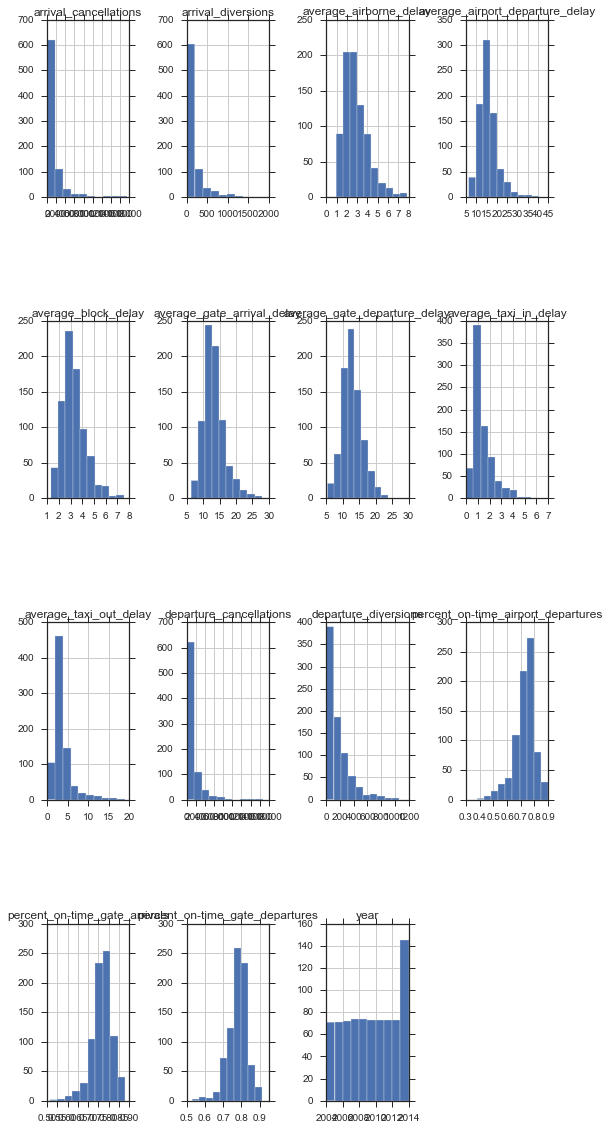

In [448]:
airport_totaldf [var_list].hist () 
plt.subplots_adjust(top = 2.8, wspace = .7, hspace = .7)

#### 4.2 Find correlations in the data

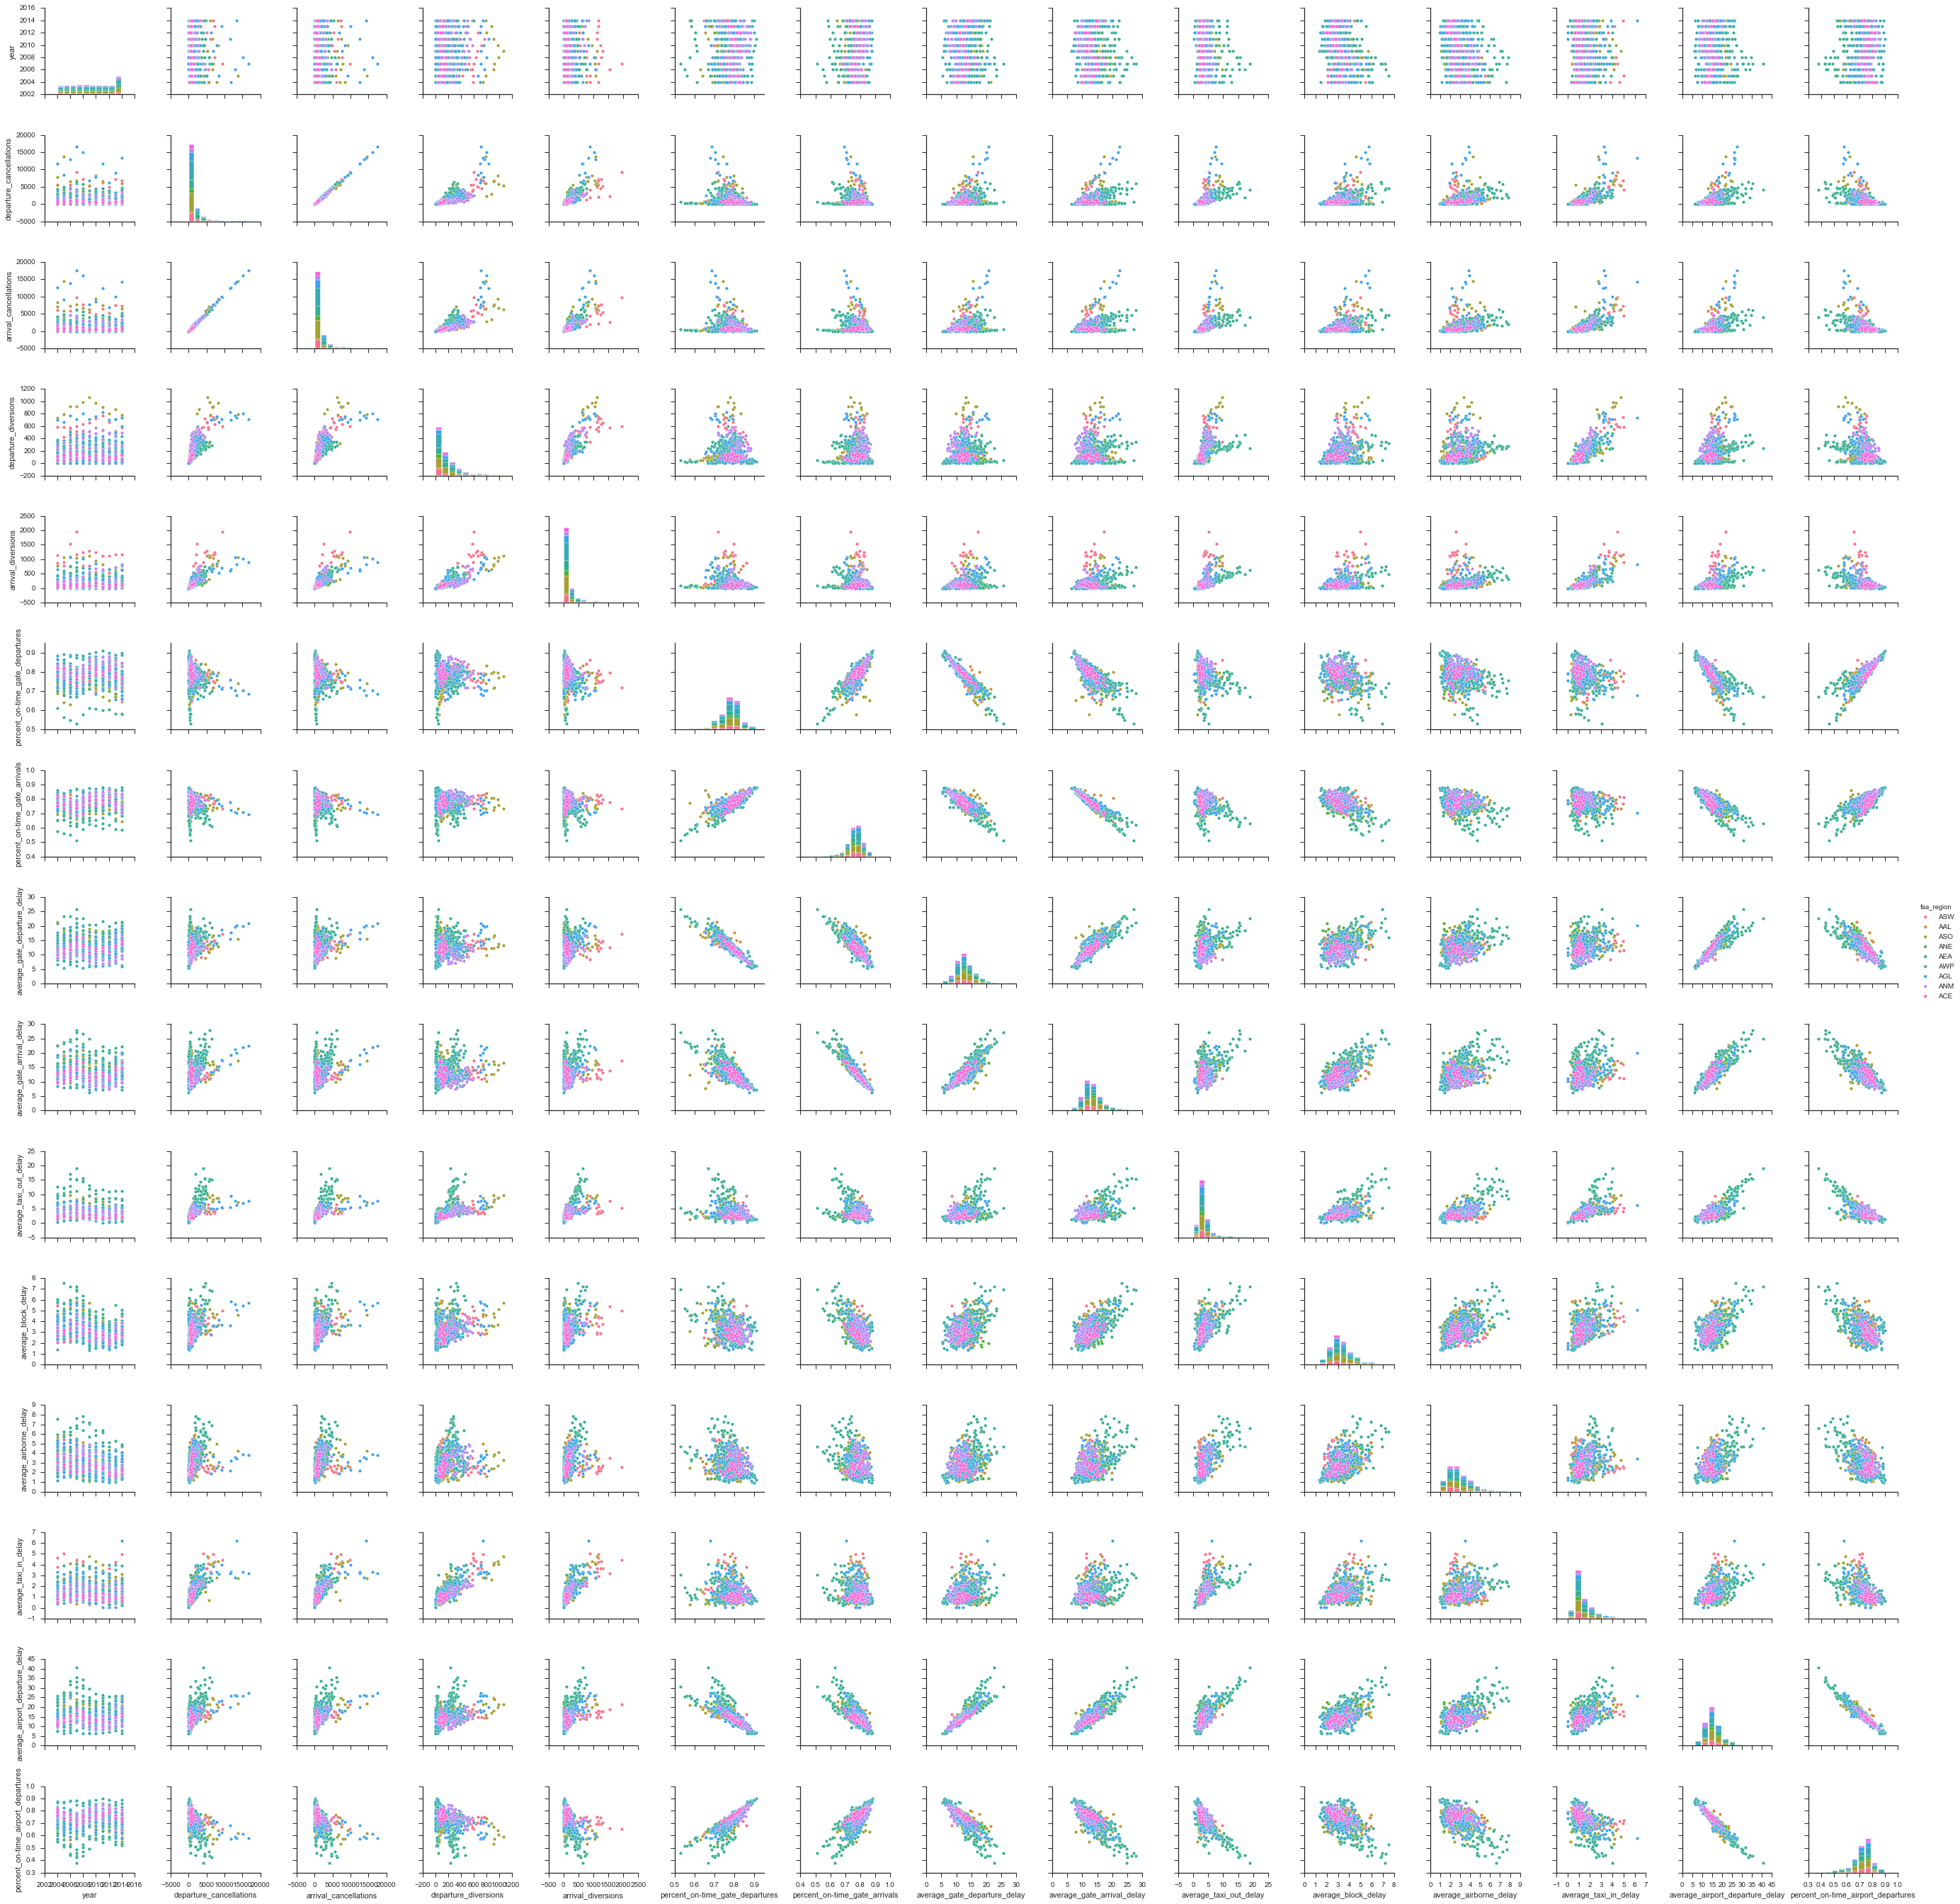

In [449]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=airport_totaldf[var_list], hue="faa_region", dropna=True) 

,index,key,faa_region,county,city,state,latitude,longitude,boundary_data_available,airport,...,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,ap_type_2
0,1223,2348.0,ASW,BERNALILLO,ALBUQUERQUE,NM,35.040194,-106.609194,Yes,ABQ,...,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87,1
1,1223,2348.0,ASW,BERNALILLO,ALBUQUERQUE,NM,35.040194,-106.609194,Yes,ABQ,...,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24,1
2,1223,2348.0,ASW,BERNALILLO,ALBUQUERQUE,NM,35.040194,-106.609194,Yes,ABQ,...,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82,1
3,1223,2348.0,ASW,BERNALILLO,ALBUQUERQUE,NM,35.040194,-106.609194,Yes,ABQ,...,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71,1
4,1223,2348.0,ASW,BERNALILLO,ALBUQUERQUE,NM,35.040194,-106.609194,Yes,ABQ,...,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48,1


In [1134]:
# correlations
temp = airport_totaldf.loc[:,var_list_numeric].corr()
temp

,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,percent_on-time_gate_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_gate_arrival_delay,average_taxi_out_delay,average_block_delay,average_airborne_delay,average_taxi_in_delay,average_airport_departure_delay,percent_on-time_airport_departures
departure_cancellations,1.000000,0.997464,0.796385,0.792253,-0.183962,-0.113363,0.291753,0.325605,0.599671,0.396928,0.376828,0.723515,0.504939,-0.466213
arrival_cancellations,0.997464,1.000000,0.814378,0.793773,-0.172420,-0.094130,0.275300,0.305527,0.588159,0.388365,0.367273,0.730266,0.487547,-0.453081
departure_diversions,0.796385,0.814378,1.000000,0.840401,-0.051995,0.067575,0.124451,0.127359,0.554316,0.330366,0.280685,0.816581,0.360954,-0.357375
arrival_diversions,0.792253,0.793773,0.840401,1.000000,-0.142091,-0.028064,0.218199,0.219782,0.581730,0.379282,0.322749,0.785480,0.444050,-0.431068
percent_on-time_gate_departures,-0.183962,-0.172420,-0.051995,-0.142091,1.000000,0.782703,-0.913107,-0.712282,-0.212539,-0.342640,-0.265446,-0.162607,-0.764464,0.818598
percent_on-time_gate_arrivals,-0.113363,-0.094130,0.067575,-0.028064,0.782703,1.000000,-0.800603,-0.922723,-0.287357,-0.550010,-0.271240,-0.087212,-0.712975,0.695697
average_gate_departure_delay,0.291753,0.275300,0.124451,0.218199,-0.913107,-0.800603,1.000000,0.850259,0.339046,0.435036,0.328084,0.249073,0.886479,-0.826633
average_gate_arrival_delay,0.325605,0.305527,0.127359,0.219782,-0.712282,-0.922723,0.850259,1.000000,0.469840,0.643705,0.392012,0.266640,0.838877,-0.753545
average_taxi_out_delay,0.599671,0.588159,0.554316,0.581730,-0.212539,-0.287357,0.339046,0.469840,1.000000,0.579919,0.642913,0.665664,0.733528,-0.725766
average_block_delay,0.396928,0.388365,0.330366,0.379282,-0.342640,-0.550010,0.435036,0.643705,0.579919,1.000000,0.514464,0.482421,0.589096,-0.561451


In [1137]:
temp.to_csv('feature_corr2.csv', sep=',', encoding='utf-8')

#### There is correlation in delay data.

We can see that departure_cancellations is highly correlated with arrival_cancellation, the other two features highly correlated are arrival_diversions and average_taxi_in_delay.

#### 4.3 What is the value of understanding correlations before PCA? 

Answer:  The more correlation between features the better PCA will be able to condense info to fewer dimensions. 

#### 4.4 Validate your findings using statistical analysis

In [1124]:
# description of numeric columns 
temp = airport_totaldf[var_list_numeric].describe()
temp.iloc[1:8, 0:].T

,mean,std,min,25%,50%,75%,max
departure_cancellations,1299.314143,1840.877193,0.0000,349.00000,670.0000,1483.5000,16618.0000
arrival_cancellations,1341.068836,1980.459892,0.0000,314.50000,653.0000,1542.0000,17571.0000
departure_diversions,174.250313,172.638408,0.0000,62.00000,111.0000,237.0000,1064.0000
arrival_diversions,170.256571,229.162686,0.0000,41.00000,84.0000,190.0000,1948.0000
percent_on-time_gate_departures,0.779123,0.052279,0.5299,0.75310,0.7841,0.8107,0.9097
percent_on-time_gate_arrivals,0.766864,0.050502,0.5136,0.74215,0.7705,0.7976,0.8803
average_gate_departure_delay,12.890250,3.036474,5.3500,10.83000,12.5400,14.6200,25.8400
average_gate_arrival_delay,13.428811,3.251647,6.3300,11.27000,12.9700,14.9350,27.7800
average_taxi_out_delay,3.683292,2.337325,0.1000,2.30000,3.0500,4.2200,18.9400
average_block_delay,3.290826,0.989275,1.3300,2.61500,3.1300,3.8150,7.5200


In [969]:
# set features
X= airport_totaldf[var_list_numeric]

In [1004]:
# scale the data
x_scale = StandardScaler().fit_transform(airport_totaldf.loc[:,var_list_numeric])

In [1051]:
# implement k-means clustering 
from sklearn import cluster, metrics
s = []
for k in range(2, 10):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(x_scale)
    labels = kmeans.labels_
    print k, silhouette_score(x_scale,kmeans.labels_)
    
    s.append(silhouette_score(x_scale,kmeans.labels_))

    #s.append(metrics.silhouette_score(x_scale, labels, metric='euclidean'))
  

2 0.454566877973
3 0.26398633586
4 0.249082542485
5 0.260366651455
6 0.234892857437
7 0.245236835778
8 0.217239806442
9 0.22221649328


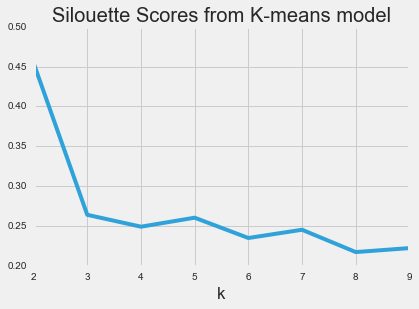

In [1125]:
# plot and see the performance of the model when different clusters are defined
f, (ax1) = plt.subplots(1,1)
ax1.plot(range(2,10), s)
ax1.set_title("Silouette Scores from K-means model")
ax1.set_xlabel("k")



In [1053]:
# set the k-means model's clusters into 2 which optimize the model
k = 2
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(x_scale)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
# assign labels of the cluster each record was in
airport_totaldf['label'] = labels
metrics.silhouette_score(x_scale, labels)

0.45456687797264922

In [1054]:
cluster_labels = kmeans.fit_predict(x_scale)

#### 4.5 How can you improve your overall analysis? 

Answer: we can use PCA to see if we can improve the performance of model training and make it more efficient and reduce dimemsionality

### Part 5: Perform a PCA

#### 5.1 Conduct the PCA

In [1126]:
# number of pcs to use 
n = []
for i in range(1,6):
    pca = PCA(n_components=i)
    pca.fit(x_scale)
    print i, sum(pca.explained_variance_ratio_)   
    n.append(sum(pca.explained_variance_ratio_))

1 0.537637782536
2 0.777554631446
3 0.85046160901
4 0.895738164258
5 0.928818419271


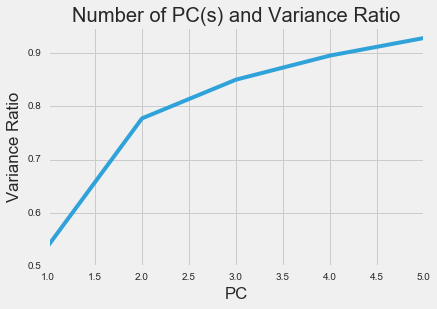

In [1132]:
# plot pcs to use and variance ratio
f, (ax1) = plt.subplots(1,1)
ax1.plot(range(1,len(n)+1), n)
ax1.set_title("Number of PC(s) and Variance Ratio")
ax1.set_xlabel("PC")
ax1.set_ylabel("Variance Ratio")

In [1111]:
# let's use 3 components (85% of variance) and fit the pca model again
pca = PCA(n_components=3)
airport_pcadf = pd.DataFrame(pca.fit_transform(x_scale), columns = ["pc1","pc2","pc3"])

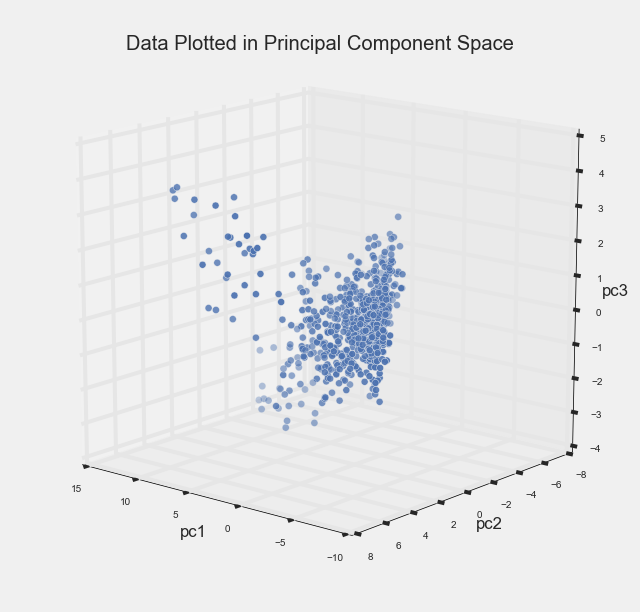

In [1112]:
# plot data in pc space
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(airport_pcadf["pc1"],airport_pcadf["pc2"],airport_pcadf["pc3"],\
            s=50 ,  cmap='rainbow' )

ax.set(xlabel="pc1",ylabel="pc2",zlabel="pc3")
ax.set_title("Data Plotted in Principal Component Space")
ax.view_init(15, 130)
plt.draw()

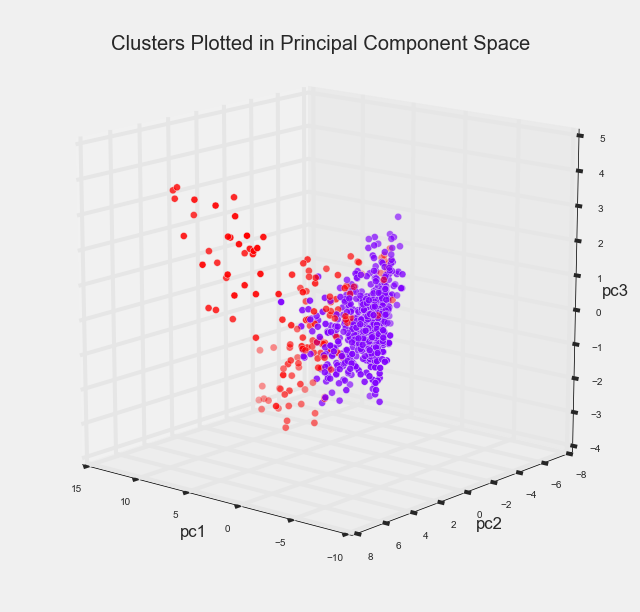

In [1105]:
# plot Clusters in pc space
fig = plt.figure(figsize=(10,10))
colors=plt.cm.spectral(cluster_labels.astype(float)/airport_totaldf['label'])

ax = fig.add_subplot(111, projection='3d')
ax.scatter(airport_pcadf["pc1"],airport_pcadf["pc2"],airport_pcadf["pc3"],\
            s=50 ,c=labels,  cmap='rainbow' )

ax.set(xlabel="pc1",ylabel="pc2",zlabel="pc3")
ax.set_title("Clusters Plotted in Principal Component Space")
ax.view_init(15, 130)
plt.draw()


In [1077]:
# Do this to create gif images using view_init
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

colors=plt.cm.spectral(cluster_labels.astype(float)/airport_totaldf['label'])

ax.scatter(airport_pcadf["pc1"],airport_pcadf["pc2"],airport_pcadf["pc3"],\
           s=50, c=labels, cmap='rainbow' )
ax.set(xlabel="pc1",ylabel="pc2",zlabel="pc3")
ax.set_title("Clusters Plotted in Principal Component Space")
#Rotate the axes programatically
for i in range(0,360,15):
    ax.view_init(15, i)
    filename="rotate"+str(i)+".jpg"
    plt.savefig(filename)
        
plt.close(fig)

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

In [1061]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
X1 = x_scale
Z = linkage(X1, 'ward')
c, coph_dists = cophenet(Z, pdist(X1))
c

0.65406177974204938

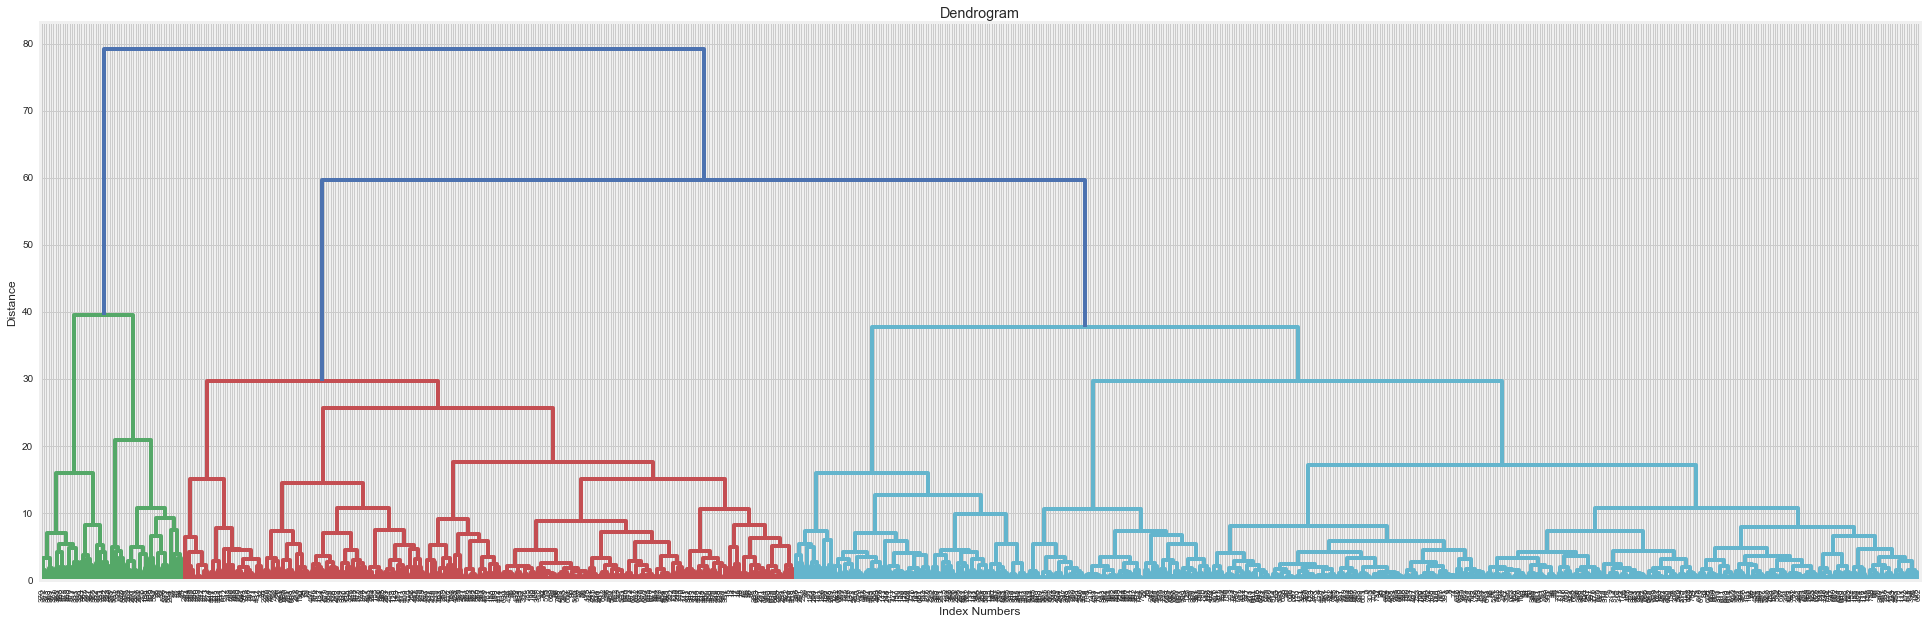

In [1062]:
#  hierarchical
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()


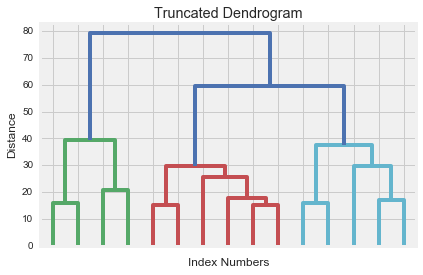

In [1063]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [1064]:
# test silhouette score for different cuts
for max_d in range(10,70,10):
    clusters = fcluster(Z, max_d, criterion='distance')
    print max_d, silhouette_score(x_scale,clusters)

10 0.145446626337
20 0.203728961833
30 0.243071067868
40 0.259277992483
50 0.259277992483
60 0.546606806146


In [1067]:
clusters = fcluster(Z, 60, criterion='distance')

In [1068]:
#check number of members of each cluster for hierarchical vs kmeans
print Counter(clusters)
print Counter(kmeans.labels_)

Counter({2: 738, 1: 61})
Counter({0: 650, 1: 149})


In [1079]:
airport_totaldf.to_csv('airport.csv', sep=',', encoding='utf-8')

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

https://mariapichardo.github.io/airport-delays-analysis-using-clusters.html

Which operational features are most correlated with delays?


## We can see that departure_cancellations is highly correlated with arrival_cancellation, the other two features highly correlated are arrival_diversions and average_taxi_in_delay.

What should the airport's next steps be?

### Bonus: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied

### Please see the 3-D Plot above